Sno - Серийный номер  
ObservationDate - Дата наблюдения в ММ/ДД/ГГГГ  
Province/State - Провинция или штат наблюдения (может быть пустым, если отсутствует)  
Country/Region - Страна наблюдения  
Last Update - время в формате UTC, когда строка обновляется для данной провинции или страны. (Не стандартизирован и поэтому,   пожалуйста, очистите его перед использованием)  
Confirmed - Совокупное количество подтвержденных случаев до этой даты  
Deaths - Совокупное число смертей до этой даты  
Recovered - Совокупное количество восстановленных случаев до этой даты  

In [85]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt

import missingno as miss

import seaborn as sns

%matplotlib inline

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

In [87]:
df = pd.read_csv('data/covid_19_data.csv')

In [88]:
df_full = pd.read_csv('full_table.csv',index_col=0)

In [89]:
df['ObservationDate'] = pd.to_datetime(df.ObservationDate)
df_full['date'] = pd.to_datetime(df_full.date)

In [90]:
df = df.sort_values(by = 'ObservationDate')

In [91]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
22,23,2020-01-22,Qinghai,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
23,24,2020-01-22,Shaanxi,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
24,25,2020-01-22,Shandong,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
25,26,2020-01-22,Shanghai,Mainland China,1/22/2020 17:00,9.0,0.0,0.0


In [92]:
df['date'] = df['ObservationDate']

In [93]:
df.drop('ObservationDate', 1, inplace=True)

In [94]:
df.columns

Index(['SNo', 'Province/State', 'Country/Region', 'Last Update', 'Confirmed',
       'Deaths', 'Recovered', 'date'],
      dtype='object')

In [95]:
df = df[['SNo','date' , 'Province/State', 'Country/Region', 'Last Update', 'Confirmed',
       'Deaths', 'Recovered' ]]

In [96]:
df.columns = [i.replace('/', '').replace(' ', '').lower() for i in df.columns]

In [97]:
df.head()

,sno,date,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
22,23,2020-01-22,Qinghai,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
23,24,2020-01-22,Shaanxi,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
24,25,2020-01-22,Shandong,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
25,26,2020-01-22,Shanghai,Mainland China,1/22/2020 17:00,9.0,0.0,0.0


In [98]:
df_full.head()

,lat,long,date,provincestate,countryregion,confirmed,deaths,recovered,active
0,33.939110,67.709953,2020-01-22,NaN,Afghanistan,0,0,0.0,0.0
176,4.210484,101.975766,2020-01-22,NaN,Malaysia,0,0,0.0,0.0
177,3.202800,73.220700,2020-01-22,NaN,Maldives,0,0,0.0,0.0
178,17.570692,-3.996166,2020-01-22,NaN,Mali,0,0,0.0,0.0
179,35.937500,14.375400,2020-01-22,NaN,Malta,0,0,0.0,0.0


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   sno            306429 non-null  int64         
 1   date           306429 non-null  datetime64[ns]
 2   provincestate  228329 non-null  object        
 3   countryregion  306429 non-null  object        
 4   lastupdate     306429 non-null  object        
 5   confirmed      306429 non-null  float64       
 6   deaths         306429 non-null  float64       
 7   recovered      306429 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 21.0+ MB


In [100]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135356 entries, 0 to 136343
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   lat            135356 non-null  float64       
 1   long           135356 non-null  float64       
 2   date           135356 non-null  datetime64[ns]
 3   provincestate  41496 non-null   object        
 4   countryregion  135356 non-null  object        
 5   confirmed      135356 non-null  int64         
 6   deaths         135356 non-null  int64         
 7   recovered      135356 non-null  float64       
 8   active         135356 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 10.3+ MB


In [101]:
df_all = pd.merge(left = df, right = df_full, on = ['date', 'countryregion'])

In [113]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488336 entries, 0 to 488335
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   sno            488336 non-null  int64         
 1   date           488336 non-null  datetime64[ns]
 2   countryregion  488336 non-null  object        
 3   lastupdate     488336 non-null  object        
 4   lat            488336 non-null  float64       
 5   long           488336 non-null  float64       
 6   active         488336 non-null  float64       
 7   deaths         488336 non-null  float64       
 8   confirmed      488336 non-null  float64       
 9   recovered      488336 non-null  float64       
 10  provincestate  405632 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 60.8+ MB


In [111]:
df_all.columns

Index(['sno', 'date', 'countryregion', 'lastupdate', 'lat', 'long', 'active',
       'deaths', 'confirmed', 'recovered', 'provincestate'],
      dtype='object')

In [107]:
df_all['deaths'] = df_all['deaths_x']
df_all['confirmed'] = df_all['confirmed_x']
df_all['recovered'] = df_all['recovered_x']
df_all['provincestate'] = df_all['provincestate_x']

In [110]:
df_all.drop(['provincestate_x', 'confirmed_x', 'deaths_x', 'recovered_x', 'provincestate_y', 'confirmed_y', 'deaths_y', 'recovered_y'],1, inplace=True)

<AxesSubplot:>

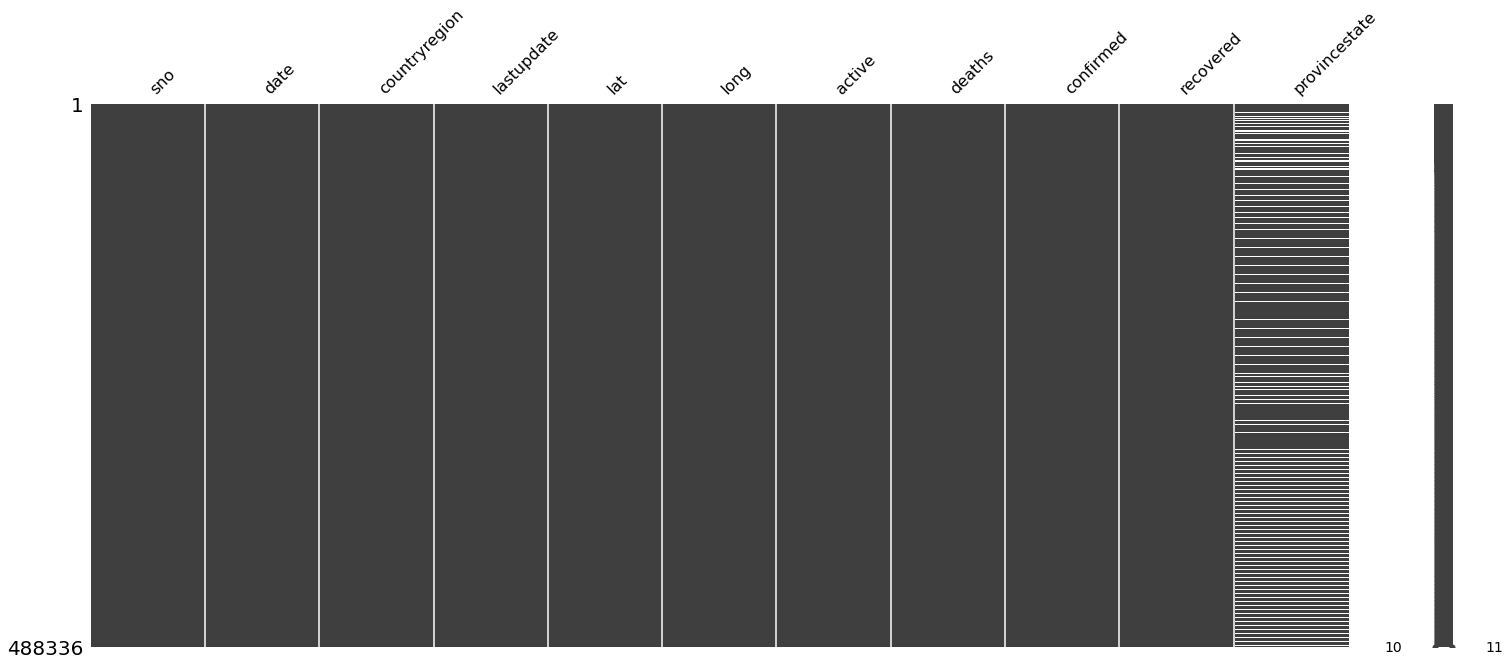

In [112]:
miss.matrix(df_all)

In [114]:
df_all.drop('provincestate',1,inplace=True)

In [116]:
df_all.drop('lastupdate',1,inplace=True)

In [117]:
df_all.to_csv('df_all.csv')